# Kaskawulsh: MCMC Test

Our overall goal find a consitent set of mass balance parameters which are regionally characersitc of the Yukon. We started by running uncoupled `Elmer/Ice` simulations using [Young et al. 2021](https://www-cambridge-org.proxy.lib.sfu.ca/core/journals/journal-of-glaciology/article/an-imbalancing-act-the-delayed-dynamic-response-of-the-kaskawulsh-glacier-to-sustained-mass-loss/350065B3C0CD9A900DCBA7D60445D583) results for the surface mass balance forcing. Each glacier need a scalar offset ranging from XX-XX $\rm{m i.e. a^{-1}}$ for the steady-state configuration to have a similar volume as it's observed volume. Now we seek to inver for the appropriate mass balance parameter in our simplified model to match the (`Elmer/Ice`) modeled net balance cruve. 

But, it appears we have "jumped the gun" a little. We have yet to confirm whether our simple model, following Gilbert et al. 2016 is able to recreate the reults from Young et al. 2021. It's very possible we may need to introduce additional paramater, like a precipitation bias correction, for our model to match the Young et al. 2021 results. This is what we explore below! 


Collection of links / rescources: 

- [Paper about non-centered distribution](https://arxiv.org/pdf/1312.0906.pdf)

- [Young et al. 2020 Supplementary Material](https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S0022143020001070/resource/name/S0022143020001070sup001.pdf)

- [Rounce et al. 2020](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/61D8956E9A6C27CC1A5AEBFCDADC0432/S0022143019000911a.pdf/quantifying_parameter_uncertainty_in_a_largescale_glacier_evolution_model_using_bayesian_inference_application_to_high_mountain_asia.pdf)

- [Rounce et al. 2020 Supplementary Material](https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S0022143019000911/resource/name/S0022143019000911sup001.pdf)

- [Huss and Hock, 2015](https://www.readcube.com/articles/10.3389/feart.2015.00054)

- [Huss and Hock, 2015 Supplementary Material](file:///Users/andrewnolan/Downloads/supplementary%20material.pdf)

In [1]:
import PDD
import numpy as np
import pymc3 as pm 
import arviz as az
import xarray as xr
from numpy import random
from scipy import interpolate
import matplotlib.pyplot as plt 

plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

__Load the NetCDF with Kaskawulsh Data__: 

In [2]:
nc_fp = "../MB_tune/Young_etal_2020_ref_MB.nc"

with xr.open_dataset(nc_fp) as MB_ref: 
    z_nc = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
    
z = np.linspace(np.nanmin(z_nc), np.nanmax(z_nc), 1000)

I think I forgot account for precipitation in the form of rain, lets take a look at Katies data: 

In [3]:
nc_fp = "../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    pass

Old_A_mean =  MB_new.stack(z=('x', 'y')).Accumulation.mean().values
New_A_mean = (MB_new.stack(z=('x', 'y')).Accumulation + \
              MB_new.stack(z=('x', 'y')).Rain.values).mean().values
Temp_mean  =  MB_new.stack(z=('x', 'y')).temp.mean().values

print('A_mean (snow)        = {:+.2f}'.format(Old_A_mean))
print('A_mean (snow + rain) = {:+.2f}'.format(New_A_mean))
print('T_mean               = {:+.2f}'.format(Temp_mean))


A_mean = New_A_mean

A_mean (snow)        = +1.41
A_mean (snow + rain) = +1.53
T_mean               = -8.67


__Load the spline related data__:

In [4]:
# file paths to knots and coefs 
coefs_fp = '../../input_data/mass_balance/cubic_spline_coefs_s_1500_weighted.dat'
knots_fp = '../../input_data/mass_balance/cubic_spline_knots_s_1500_weighted.dat'

# load the knots and coefs into memory
coefs = np.loadtxt(coefs_fp)
knots = np.loadtxt(knots_fp)

# make the tck tuple used by splev 
tck = (knots, coefs, 3)

__Prediction with Spline__:

In [5]:
# Do the prediction 
mb     = interpolate.splev(z,tck)
# Add some random noise 
mb_obs = random.normal(mb, 0.35)

__Visualize Mass balance Data__: 

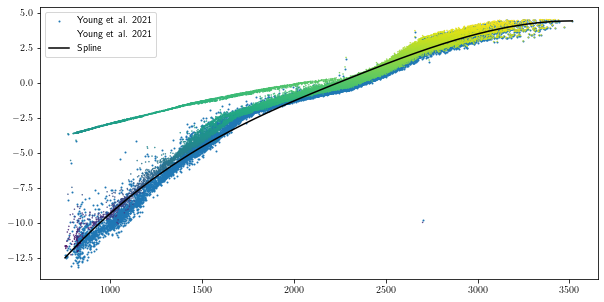

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(MB_ref.Elevation, 
           MB_ref.MB.mean('ref_run'),
           s=1,
           label='Young et al. 2021')

ax.scatter(MB_new.Elevation, 
           MB_new.MB,
           c= MB_new.MB,
           s=0.25,
           label='Young et al. 2021')

# ax.scatter(z, mb_obs, s=1, 
#            label = "Spline with noise")

ax.plot(z, mb, c='k', label = "Spline")

ax.legend()

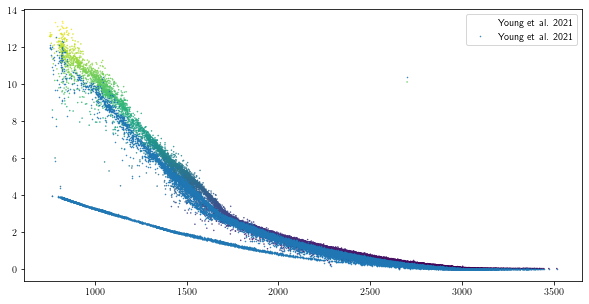

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(MB_ref.Elevation, 
           MB_ref.Melt.mean('ref_run'),
           c= MB_ref.Melt.mean('ref_run'),
           s=0.25,
           label='Young et al. 2021')

ax.scatter(MB_new.Elevation, 
           MB_new.Melt,
           c= "tab:blue",
           s=0.25,
           label='Young et al. 2021')
ax.legend()

In [8]:
stacked = MB_ref.stack(z=('x','y'))
idxs  = stacked.dropna('z').z.values
elev  = stacked.Elevation.dropna('z').values
idxs  = idxs[np.argsort(elev)]
Accum = stacked.mean('ref_run').sel(z=idxs)

In [9]:
p = np.polyfit(Accum.Elevation, Accum.Accumulation, 5)
A_hat = np.polyval(p, Accum.Elevation)

Text(0.5, 0, 'Elevation m a.s.l.')

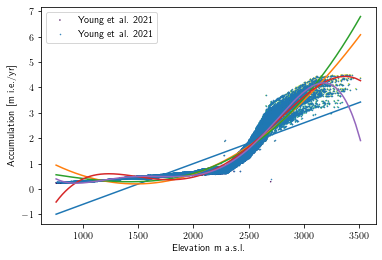

In [10]:
fig, ax = plt.subplots()

ax.scatter(Accum.Elevation, 
           Accum.Accumulation,
           c= Accum.Accumulation,
           s=0.25,
           label='Young et al. 2021')

ax.scatter(MB_new.Elevation, 
           MB_new.Accumulation,
           c= 'tab:blue',
           s=0.25,
           label='Young et al. 2021')

for k in np.arange(1,6): 
    p = np.polyfit(Accum.Elevation, Accum.Accumulation, k)
    A_hat = np.polyval(p, Accum.Elevation)
    
    ax.plot(Accum.Elevation, A_hat)
ax.legend()

ax.set_ylabel('Accumulation [m i.e./yr]')
ax.set_xlabel('Elevation m a.s.l.')

# fig.savefig('/Users/andrewnolan/Desktop/EMY_accum.png',dpi=300)

In [34]:
from scipy import optimize


def forward(x, x1, y0, k1, k2, k3 ):
    x0 = 2226
    print(y0)
    return np.piecewise(x, [x < x0, (x0 < x) & (x < x1), x1 < x], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0, k3])

p , e = optimize.curve_fit(forward, 
                           Accum.Elevation.values[::10], 
                           Accum.Accumulation.values[::10],
                           p0=[3100, 0.0, 10e-4, 10e-3, 4.1])

0.0
0.0
0.0
0.0
1.4901161193880158e-08
0.0
0.0
0.0
0.6004424812323453
0.6004424812323453
0.6004424901796356
0.6004424812323453
0.6004424812323453
0.6004424812323453
0.6004424790680737


In [25]:
7.69007308e-01

0.769007308

In [26]:
p

array([3.10000000e+03, 6.00442479e-01, 2.14347103e-04, 3.97468604e-03,
       3.99733372e+00])

3100.0


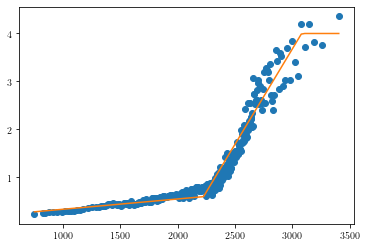

In [27]:
plt.plot(Accum.Elevation.values[::100], Accum.Accumulation.values[::100], "o")
plt.plot(Accum.Elevation.values[::100], forward(Accum.Elevation.values[::100], *p))

In [ ]:
Accum.Elevation.values[::10].shape

In [ ]:
# dictionary of PDD model parameters
const =  dict(T_m   = 0.0,
              T_rs   = 1.0,
              A_mean = A_mean * 910., 
              α      = 10.5, 
              T_ma   = Temp_mean,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196,
              T_σ    = 8.6,
              ref_z  = 2193)

# initialize the PDD melt model class
Accum_def = PDD.Accumulation_default(**const)

In [ ]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=0.5e-4, upper=5e-4)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    A_snow = Accum_def.tt_forward(Accum.Elevation.values[::10], grad_a)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=A_snow, sigma=sigma, observed=Accum.Accumulation.values[::10])
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
#     startvals = pm.find_MAP() 
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True);
    
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["grad_a", "sigma"])

In [ ]:

plt.scatter(Accum.Elevation.values, 
            Accum.Accumulation.values, 
            s=0.5)

for i, j in enumerate(np.random.randint(0,3999,499)):
    grad_a = ppc["grad_a"][j]        
    A = Accum_def.eval_forward(np.sort(Accum.Elevation.values[::10]), grad_a)
    
    plt.plot(np.sort(Accum.Elevation.values[::10]), A, c='tab:orange', alpha=0.5)
    
plt.savefig('/Users/andrewnolan/Desktop/MCMC_Accum.png', dpi=300)

In [ ]:
fancy_std = np.array([5.58899152, 5.5899782 , 5.59030049, 5.58996848, 5.58899216,
       5.58738151, 5.58514645, 5.58229684, 5.57884251, 5.57479322,
       5.5701587 , 5.56494864, 5.55917264, 5.55284029, 5.54596112,
       5.53854461, 5.53060018, 5.52213723, 5.51316507, 5.50369299,
       5.49373023, 5.48328597, 5.47236934, 5.46098944, 5.44915528,
       5.43687587, 5.42416013, 5.41101696, 5.39745518, 5.38348359,
       5.36911092, 5.35434586, 5.33919704, 5.32367306, 5.30778244,
       5.29153367, 5.27493519, 5.25799538, 5.24072259, 5.22312508,
       5.2052111 , 5.18698883, 5.16846639, 5.14965188, 5.13055332,
       5.11117869, 5.09153592, 5.07163289, 5.05147742, 5.03107729,
       5.01044023, 4.98957389, 4.96848592, 4.94718387, 4.92567527,
       4.90396757, 4.88206821, 4.85998453, 4.83772386, 4.81529344,
       4.7927005 , 4.76995219, 4.7470556 , 4.7240178 , 4.70084578,
       4.67754649, 4.65412682, 4.63059363, 4.60695369, 4.58321375,
       4.55938049, 4.53546056, 4.51146051, 4.4873869 , 4.46324618,
       4.43904479, 4.41478909, 4.3904854 , 4.36613998, 4.34175904,
       4.31734875, 4.29291519, 4.26846443, 4.24400247, 4.21953523,
       4.19506863, 4.17060849, 4.14616059, 4.12173067, 4.0973244 ,
       4.07294741, 4.04860526, 4.02430346, 4.00004748, 3.97584273,
       3.95169455, 3.92760825, 3.90358906, 3.87964219, 3.85577275,
       3.83198584, 3.80828648, 3.78467964, 3.76117023, 3.73776313,
       3.71446314, 3.69127501, 3.66820344, 3.64525307, 3.62242849,
       3.59973424, 3.57717478, 3.55475455, 3.53247792, 3.51034918,
       3.48837261, 3.4665524 , 3.4448927 , 3.42339759, 3.40207111,
       3.38091725, 3.35993992, 3.33914299, 3.31853028, 3.29810553,
       3.27787245, 3.25783468, 3.23799581, 3.21835936, 3.19892882,
       3.1797076 , 3.16069907, 3.14190652, 3.12333321, 3.10498233,
       3.08685701, 3.06896034, 3.05129534, 3.03386497, 3.01667214,
       2.99971969, 2.98301044, 2.96654711, 2.95033238, 2.93436888,
       2.91865916, 2.90320575, 2.88801109, 2.87307757, 2.85840753,
       2.84400324, 2.82986694, 2.81600077, 2.80240685, 2.78908722,
       2.77604387, 2.76327873, 2.75079368, 2.73859053, 2.72667103,
       2.71503689, 2.70368974, 2.69263116, 2.68186269, 2.67138578,
       2.66120184, 2.65131222, 2.6417182 , 2.63242102, 2.62342185,
       2.6147218 , 2.60632192, 2.5982232 , 2.59042659, 2.58293296,
       2.57574312, 2.56885784, 2.56227781, 2.55600367, 2.55003599,
       2.54437531, 2.53902208, 2.53397669, 2.5292395 , 2.52481078,
       2.52069075, 2.51687957, 2.51337735, 2.51018413, 2.50729989,
       2.50472454, 2.50245796, 2.50049993, 2.49885021, 2.49750846,
       2.49647432, 2.49574733, 2.49532699, 2.49521275, 2.49540398,
       2.4959    , 2.49670005, 2.49780334, 2.499209  , 2.5009161 ,
       2.50292364, 2.50523058, 2.50783582, 2.51073816, 2.51393639,
       2.5174292 , 2.52121524, 2.52529308, 2.52966126, 2.53431821,
       2.53926235, 2.54449201, 2.55000545, 2.55580089, 2.56187648,
       2.56823029, 2.57486037, 2.58176466, 2.58894107, 2.59638743,
       2.60410153, 2.61208106, 2.62032369, 2.62882699, 2.6375885 ,
       2.64660568, 2.65587591, 2.66539655, 2.67516486, 2.68517806,
       2.69543329, 2.70592763, 2.7166581 , 2.72762167, 2.73881523,
       2.75023561, 2.76187958, 2.77374383, 2.78582502, 2.79811972,
       2.81062443, 2.82333562, 2.83624967, 2.84936289, 2.86267155,
       2.87617184, 2.8898599 , 2.90373178, 2.91778348, 2.93201095,
       2.94641006, 2.96097662, 2.97570636, 2.99059498, 3.00563808,
       3.02083122, 3.03616988, 3.05164948, 3.06726538, 3.08301287,
       3.09888718, 3.11488346, 3.13099682, 3.14722228, 3.16355481,
       3.17998931, 3.19652061, 3.2131435 , 3.22985266, 3.24664274,
       3.26350831, 3.28044388, 3.29744389, 3.31450272, 3.33161468,
       3.34877401, 3.36597488, 3.38321142, 3.40047767, 3.4177676 ,
       3.43507514, 3.45239412, 3.46971834, 3.48704149, 3.50435725,
       3.52165917, 3.53894078, 3.55619554, 3.57341681, 3.59059791,
       3.6077321 , 3.62481255, 3.64183237, 3.65878462, 3.67566227,
       3.69245823, 3.70916536, 3.72577642, 3.74228413, 3.75868114,
       3.77496001, 3.79111326, 3.80713333, 3.82301258, 3.83874333,
       3.85431781, 3.86972819, 3.88496656, 3.90002498, 3.91489539,
       3.9295697 , 3.94403974, 3.95829726, 3.97233396, 3.98614146,
       3.99971132, 4.01303502, 4.02610399, 4.03890956, 4.05144303,
       4.06369561, 4.07565842, 4.08732257, 4.09867903, 4.10971877,
       4.12043263, 4.13081142, 4.14084586, 4.15052662, 4.15984429,
       4.16878939, 4.17735236, 4.18552359, 4.1932934 , 4.20065201,
       4.20758962, 4.21409631, 4.22016212, 4.22577702, 4.2309309 ,
       4.23561357, 4.2398148 , 4.24352427, 4.24673158, 4.24942628,
       4.25159785, 4.25323568, 4.25432909, 4.25486737, 4.25483968,
       4.25423516, 4.25304284, 4.25125171, 4.24885068, 4.24582857,
       4.24217415, 4.23787612, 4.2329231 , 4.22730363, 4.2210062 ])

__Initialize our Mass Balance Model__:

These are the reference model parameters. They may need to be changed later

In [ ]:
# dictionary of PDD model parameters
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              A_mean = A_mean * 910., 
              α      = 10.5, 
              T_ma   = Temp_mean,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196,
              T_σ    = 1.5*fancy_std[:,np.newaxis],
#               T_σ    = 8.6,
              ref_z  = 2193)

# initialize the PDD melt model class
melt_model = PDD.PDD_melt_model(**const)

__Paramter Inversion with the MCMC Model__: 

In [ ]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=1.5,  lower=0.0)
#     f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=0.1,  lower=0.0)
#     f_s_prior  = pm.Uniform("f_s", lower=2.0, upper=3.0)
    # Somewhat base of Aschwanden et al. 2019
    C_prior    = pm.TruncatedNormal("C",      mu=2.0,  sigma=0.75,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=0.5e-4, upper=5e-4)
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.2,  lower=0.0, upper=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    melt = melt_model.tt_forward(z, f_s_prior, C_prior, grad_a, f_r_prior)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=melt, sigma=sigma, observed=mb_obs)
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
#     startvals = pm.find_MAP() 
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True, 
                      target_accept=0.99);

In [ ]:
az.plot_trace(trace );
plt.tight_layout()

In [ ]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "sigma"])

In [ ]:
ppc

In [ ]:
def plot_parts(z, params, ax, i ): 
    MB, A, R, M = melt_model.eval_forward(z, *params)
    
            
    ELA_idx = np.argpartition(np.abs(MB), 2)[:2]
    ELA = np.mean(z[ELA_idx])
    
    if i == 0: 
        ax.plot(z, A , alpha=1.0, c='#377eb8', label='Accumulation')
        ax.plot(z, R , alpha=1.0, c='#4daf4a', label='Refreezing')
        ax.plot(z, M , alpha=1.0, c='#984ea3', label='Melt')
        ax.plot(z, MB, alpha=1.0, c='#e41a1c', label='Mass Balance')
        
        ax.axvline(ELA, c='grey', lw=0.5, alpha=1.0, label='Modeled ELA')
        ax.axhline(0, c='k', ls=':', lw=1.0, alpha=0.5)
    else:
        ax.plot(z, A , alpha=0.1, c='#377eb8')
        ax.plot(z, R , alpha=0.1, c='#4daf4a')
        ax.plot(z, M , alpha=0.1, c='#984ea3')
        ax.plot(z, MB, alpha=0.1, c='#e41a1c')
        
        ax.axvline(ELA, c='grey', lw=0.5, alpha=0.1)
        

In [ ]:
[np.mean(ppc[key]) for key in list(ppc)[:-1]]

In [ ]:
fig, ax = plt.subplots()

for i, j in enumerate(np.random.randint(0,3999,499)):
    params = []

    for key in list(ppc)[:-1]: 
        if len(ppc[key].shape) == 2: 
            params.append(ppc[key][j])
        else: 
            params.append(ppc[key][j])

    plot_parts(z, params, ax, i)
    
ax.scatter(z, mb_obs, c='#ff7f00', label='Elmer Mass Balance')
ax.legend()

param_means = [np.mean(ppc[key])*1000*100 if key == 'grad_a' else np.mean(ppc[key]) for key in list(ppc)[:-1]]
params_string = r"$\bar{{f}}_{{\rm s}} = {:.2f} \rm{{\;kg \;m^{{-2}} \; a^{{-1}} \; K^{{-1}}}}, \bar{{C}} = {:.2f} \;[-], \bar{{\Delta P/\Delta z}} = {:.2f} \;\%/\rm{{km}}, \bar{{f}}_{{\rm }} = {:.1f} \;[-]$"
ax.set_title(params_string.format(*param_means))
             
# fig.savefig(f'Kaskawulsh_T_ma={T_ma}_A_mean={A_mean}_no_enhancement.pdf', bbox_inches='tight', facecolor='w')
fig.savefig('/Users/andrewnolan/Desktop/fancystd_w_priors_from_references.png', dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
 MB, A, R, M = melt_model.eval_forward(z, *params)

In [ ]:
params_string = r"$\bar{{f}}_{{\rm s}} = {:.2f} \rm{{kg \;m^{-2} \; a^{-1} \; K^{-1}}}, \bar{{C}} = {:.2f} [-], \bar{{\Delta P/\Delta z}} = {:.2f} \%/\rm{{km}}, \bar{{f}}_{{\rm 5}} = {:.1f} [-]$"
params_string.format(*[np.mean(ppc[key]) for key in list(ppc)[:-1]])

In [ ]:
2.53 * 2.46

In [ ]:
[np.mean(ppc[key])*1000*100 if key == 'grad_a' else np.mean(ppc[key]) for key in list(ppc)[:-1]]

__PDD Model w/ Bias Correction__: 

We start with the same reference parameter, but the forward model now includes an additive and multiplicative factor for the temperature and percipitation (respectively). 

In [ ]:
# dictionary of PDD model parameters
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              A_mean = A_mean * 910., 
              α      = 10.5, 
              T_ma   = T_ma,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196, 
              ref_z  = 2193)

# initalize the PDD melt model class
enhanced = PDD.PDD_enhanced(**const)

In [ ]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=1.5,  lower=0.0)
    # constant relating f_snow to f_ice
    C_prior    = pm.TruncatedNormal("C",      mu=2.0,  sigma=0.75,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=0.5e-4, upper=5e-4)
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.2,  lower=0.0, upper=1)
    # Temperature bias 
    #T_b_prior   = pm.HalfCauchy("T_bias", beta=1.0)
    # Precipitation bias 
    P_b_prior   = pm.HalfCauchy("P_bias", beta=1.0)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    melt = enhanced.tt_forward(z, f_s_prior, C_prior, grad_a, f_r_prior, P_b_prior)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=melt, sigma=sigma, observed=mb_obs)
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
    #startvals = pm.find_MAP(),
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True,
                      target_accept=0.99);

In [ ]:
az.plot_trace(trace );
plt.tight_layout()

In [ ]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "P_bias", "sigma"])

In [ ]:
def plot_parts(z, params, ax, i ): 
    MB, A, R, M = enhanced.eval_forward(z, *params)
    
            
    ELA_idx = np.argpartition(np.abs(MB), 2)[:2]
    ELA = np.mean(z[ELA_idx])
    
    if i == 0: 
        ax.plot(z, A , alpha=1.0, c='#377eb8', label='Accumulation')
        ax.plot(z, R , alpha=1.0, c='#4daf4a', label='Refreezing')
        ax.plot(z, M , alpha=1.0, c='#984ea3', label='Melt')
        ax.plot(z, MB, alpha=1.0, c='#e41a1c', label='Mass Balance')
        
        ax.axvline(ELA, c='grey', lw=0.5, alpha=1.0, label='Modeled ELA')
        
    else:
        ax.plot(z, A , alpha=0.1, c='#377eb8')
        ax.plot(z, R , alpha=0.1, c='#4daf4a')
        ax.plot(z, M , alpha=0.1, c='#984ea3')
        ax.plot(z, MB, alpha=0.1, c='#e41a1c')
        
        ax.axvline(ELA, c='grey', lw=0.5, alpha=0.1)
        

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

for i, j in enumerate(np.random.randint(0,3999,499)):
    params = []

    for key in list(ppc)[:-1]: 
        if len(ppc[key].shape) == 2: 
            params.append(ppc[key][j])
        else: 
            params.append(ppc[key][j])

    plot_parts(z, params, ax, i)
    
ax.scatter(z, mb_obs, c='#ff7f00', label='Elmer Mass Balance')
ax.legend()

ax.set_title("$\\bar{{T}}={} ^\\circ C, \;\; \\bar{{P}}={} \; \\rm{{m i.e. y}}^{{-1}}$, $k_p$={:.2f} + $\\sigma=$1.5".format(T_ma, A_mean, ppc['P_bias'].mean()))
fig.savefig(f'Kaskawulsh_T_ma={T_ma}_A_mean={A_mean}_w_enhancement_sigma=1.5.pdf', bbox_inches='tight', facecolor='w')


### Misc: 
Testing linear interploation of snow / rain accumualtion about threshold following Rounce et al. 2020. 

In [ ]:
doy  = np.arange(1,366)[:, np.newaxis]

plt.plot(doy, enhanced._air_temp(z).mean(axis=1))
plt.plot(doy, np.random.normal(enhanced._air_temp(z).mean(axis=1), 2.5))
# plt.plot(z, (enhanced._air_temp(z)+np.random.normal(0, 10, enhanced._air_temp(z).shape)).mean(axis=0))

In [ ]:
def air_temp(z):
    T_ma   = -6.67; ΔTΔz  = 6.5E-3, 
    T_p    = 196;  ref_z  = 2193
    α      = 10.5
    
    doy  = np.arange(1,366)[:, np.newaxis]
    Temp = α*np.cos( 2*np.pi*(doy-T_p)/365 ) + \
           ΔTΔz*(ref_z-z)+T_ma

    return Temp

T_rs = 1.0
T = air_temp(z)
T_noisy = (T + np.random.normal(0, 1.0, (365, 1000)))

test = np.piecewise(T_noisy, 
             [T_noisy <= T_rs-1, 
              T_noisy >= T_rs+1,
              (T_rs-1 < T_noisy) & (T_noisy < T_rs+1) ], 
             [1, 0, lambda T: 0.5 + (T - T_rs)/2])/365

# tmp = np.where((enhanced.T_rs-1 < T) & (T < enhanced.T_rs+1), 0.5+(T-enhanced.T_rs)/2, T)
# tmp = np.where(tmp <= enhanced.T_rs - 1, 1 , tmp)
# tmp = np.where(tmp >= enhanced.T_rs + 1, 0 , tmp)
# test2 = tmp / 365

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(z, np.where(T_noisy<T_rs, 1/365, 0.0).sum(axis=0), label='noisy' )
plt.plot(z, test.sum(axis=0))
ax.plot(z, np.where(T<T_rs, 1/365, 0.0).sum(axis=0), label='noise free')

ax.legend()
ax.set_xlabel('Elevation m a.s.l.')
ax.set_ylabel('Fraction of Precip. that falls as Snow')
fig.savefig('delta_w_noise.png', dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
t_noisy = (T + np.random.normal(0.0, fancy_std[:,np.newaxis], (365, 1)))

plt.plot(z, t_noisy.mean(axis=0))

In [ ]:
plt.plot(doy, t_noisy.mean(axis=1))

In [ ]:
t_noisy.mean(axis=1).std()

In [ ]:
np.std(T.mean(axis=0))

In [ ]:
doy  = np.arange(1,366)[:, np.newaxis]

plt.plot(doy, np.random.normal(T.mean(axis=1), 1.0))
plt.plot(doy, T.mean(axis=1))
